# Introduction

Code and Analysis provided and written by Nicholas Lin - nl1637@nyu.edu

Given a dataset provided by the New York City Department of Education, I aimed to use features within the dataset to determine whether several characteristics of NYC middle schools predict admission to one of 8 high selective public high schools (Stuyvesant, Bronx Science, etc.) within New York City, which will be referred to from now on as a **HSPHS**. Given this, further consideration has to be given that admission to a HSPHS is contingenet upon applying and scoring sufficiently high on the Specialized High Schools Admissions Test **(SHSAT)** which is an independently produced and anonymously graded standardized test.

Import relevant packages and modules:

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn as sk
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

## The Dataset

The dataset **(middleSchoolData.csv)** contains data from all 594 middle schools within New York City, including 485 public schools and 109 charter schools with all 109 charter schools being featured within the last 109 rows of the dataset from a randomly selected year within the last 5 years. Given that each row of the dataset represents a particular school, the unit of analysis in this respect will be "school." The columns represent: 

Import the data and then inspect data features

In [9]:
from google.colab import files
uploaded = files.upload()

Saving middleSchoolData.csv to middleSchoolData (2).csv


In [12]:
import io
middleSchoolDF = pd.read_csv(io.StringIO(uploaded["middleSchoolData.csv"].decode("utf-8")))
print("Shape: ", middleSchoolDF.shape)
middleSchoolDF.tail()

Shape:  (594, 24)


,dbn,school_name,applications,acceptances,per_pupil_spending,avg_class_size,asian_percent,black_percent,hispanic_percent,multiple_percent,...,effective_school_leadership,strong_family_community_ties,trust,disability_percent,poverty_percent,ESL_percent,school_size,student_achievement,reading_scores_exceed,math_scores_exceed
589,84X538,ICAHN CHARTER SCHOOL 5,20,1,NaN,NaN,4.1,58.0,31.0,1.3,...,3.38,3.38,3.51,6.9,65.2,0.9,319.0,3.31,0.33,0.33
590,84X703,BRONX PREPARATORY CHARTER SCHOOL,22,1,NaN,NaN,0.3,47.7,50.5,0.8,...,3.56,3.75,3.66,12.2,82.9,7.8,715.0,4.33,0.55,0.56
591,84X704,KIPP ACADEMY CHARTER SCHOOL,23,1,NaN,NaN,0.2,41.3,56.5,1.4,...,3.01,2.15,3.06,17.5,87.4,10.8,1074.0,2.98,0.60,0.61
592,84X706,HARRIET TUBMAN CHARTER SCHOOL,24,1,NaN,NaN,0.4,62.9,34.6,1.3,...,NaN,NaN,NaN,8.8,79.1,11.2,680.0,2.87,0.69,0.73
593,84X717,ICAHN CHARTER SCHOOL,24,1,NaN,NaN,1.2,49.8,48.3,0.6,...,4.21,4.60,4.34,7.3,84.2,7.3,329.0,3.31,0.66,0.71


For convenience, here is a table of variable definitions:

| Column Label    | Description |
| ----------- | ----------- |
| A - B     |  NYC DOE school code and name respectively   |
| C   |  Number of applications to a HSPHS originating from school   |
| D  |  Number of applicants to a HSPHS accepted from school      |
| E   |  Per student spending in $    |
| F  |   Average class size    |
| G - K   |   Self-described ethnic identity of student body    |
| L - Q  |  Average rating of "school climte" factors perceived by students      |
| R   |  Percentage of students evaluated as disabled     |
| S   |  Percentage of students living in households below poverty line       |
| T   |  Percentage of ESL students      |
| U   |  School size (number of students in entire school)      |
| V   |   Average student achievement on state-wide standardized test      |
| W - X  |   Proportion of students exceeding state-wide expectations in reading and math     |

# 1. Correlation Between Raw Number of Applications to HSPHS Admission

I wanted to find if there was any correlation between raw number of applications and admissions to a HSPHS. I then plotted the relation between these two features and then conducted a simple statistical overview using **Pearson's r**, or the Pearson product-moment correlation coefficient. 

In [17]:
applications = middleSchoolDF["applications"]
acceptances = middleSchoolDF["acceptances"]
r = np.corrcoef(applications,acceptances)
r

array([[1.        , 0.80172654],
       [0.80172654, 1.        ]])

I obtained a Pearson's correlation coefficient of approximately **0.802** suggesting that there is a correlation between raw number of applications and subsequent admissions to a HSPHS. Understanding that this potentially did not tell the complete picture, I moved to plot the correlation and continue on with further analysis.

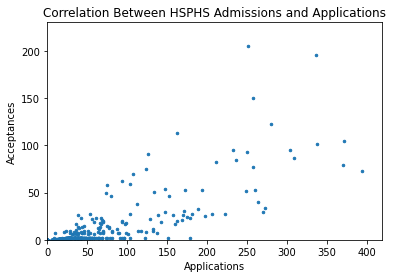

In [25]:
plt.plot(applications, acceptances, "o", markersize = 2.5)
plt.title("Correlation Between HSPHS Admissions and Applications")
plt.xlim(0, (max(applications) + 25))
plt.ylim(0, (max(acceptances) + 25))
plt.xlabel("Applications")
plt.ylabel("Acceptances");

# 2. Comparing Predictors of Admissions: Raw Applications vs. Application Rate

I next wanted to evaluate which was a better predictor of admission to a HSPHS, comparing between sheer number of applications or the actual application rate of the school. This feature of the data was more complicated as some schools did not have a application percentage therefore some simple pre-processing of the data needed to be done before analysis. This was done by simply setting application percentage to be 0 when given either a zero or null value under assumption that no students applied to a HSPHS.

In [29]:
schoolSize = (middleSchoolDF["school_size"])
#Instantiate two variables to hold values within dataframes for both application and acceptance rate
applicationRate = list()

#while loop to iterate and append new lists with values for application and acceptance rate
i = 0
while i < len(applications):
    #if loop to iterate to prevent divide by 0 error when there are no applications from a school
    if applications[i] == 0:
        applicationRate.append(0)
        i += 1
    else: 
        appRate = (applications[i] / schoolSize[i])
        #adds rate values to lists multiplied by 100 to easily visualize as a percentage
        applicationRate.append(appRate * 100)
        i += 1

We already found Pearson's correlation coefficient previously solely for sheer number of applications. Therefore I then created a Pandas DataFrame with the data containing application and acceptance rates, pre-processing any 0 or null values into NaNs for accurate processing, and then found another Pearson's correlation coefficient for the two variables based on percentages within applications and admissions.

In [52]:
appToAcceptRate = np.column_stack((applicationRate, acceptances))
rateDF = pd.DataFrame(appToAcceptRate, columns = ["Application Rate", "Acceptances"])

#Pre-process the Rate DataFrame by converting any zero or invalid values into NaNs for accurate processing
rateDF[rateDF < 0] = np.nan

#Add school names to the first column of DataFrame for easier analysis
rateDF.insert(0, "School Name", middleSchoolDF["school_name"], True)
rateDF.head(10)

,School Name,Application Rate,Acceptances
0,P.S. 034 FRANKLIN D. ROOSEVELT,1.801802,0.0
1,P.S. 140 NATHAN STRAUS,1.617251,0.0
2,P.S. 184M SHUANG WEN,9.795322,23.0
3,P.S. 188 THE ISLAND SCHOOL,0.000000,0.0
4,"TECHNOLOGY, ARTS, AND SCIENCES STUDIO",10.377358,0.0
5,UNIVERSITY NEIGHBORHOOD MIDDLE SCHOOL,6.403941,0.0
6,SCHOOL FOR GLOBAL LEADERS,7.421875,1.0
7,EAST SIDE COMMUNITY SCHOOL,2.342606,1.0
8,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",7.266436,91.0
9,TOMPKINS SQUARE MIDDLE SCHOOL,17.694370,14.0


In [51]:
#Finding Pearson's Correlation Coefficient for the two variables by rate percentage
r_byPercentage = rateDF.corr()
r_byPercentage

,Application Rate,Acceptances
Application Rate,1.000000,0.658751
Acceptances,0.658751,1.000000


Compared to the Pearson's Correlation Coefficient of approximately **0.802** when comparing raw application numbers to number of acceptances, we see that the correlation between application rate and number of acceptances, which sits at around **0.659**, is considerably lower. Therefore raw numbers of applications is still the better predictor of admissions| to a HSPHS when comparing the two. I then moved to plot the correlation of the relationship between admissions and application rate.


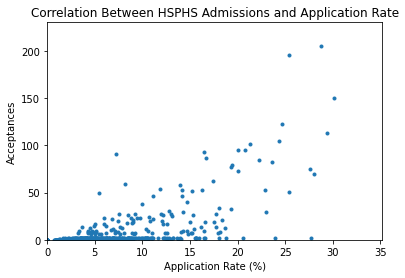

In [61]:
plt.plot(applicationRate, acceptances, "o", markersize = 3)
plt.title("Correlation Between HSPHS Admissions and Application Rate")
plt.xlim(0, (max(applicationRate) + 5))
plt.ylim(0, (max(acceptances) + 25))
plt.xlabel("Application Rate (%)")
plt.ylabel("Acceptances");

# 3. Comparing Per Student Odds of HSPHS Acceptance by School

I wanted to determine which school within the dataset had the best "per-student" odds of sending a student to a HSPHS. "Per-student" odds was calculated by simply determing which school had the highest percent of students within that school who went on to attend a HSPHS.

In [74]:
#Make a list of acceptance rate per student for each individual school
schoolAcceptRate = list()

#For loop to iterate through and append acceptance rates to each school
for i in range(len(schoolSize)):
    if schoolSize[i] == 0:
      schoolAcceptRate.append(0)
      i += 1
    else:
      acceptRate = acceptances[i] / schoolSize[i]
      schoolAcceptRate.append(acceptRate * 100)
      i += 1

#For loop to iterate through and record which school has the highest acceptance rate
maxAcceptRate = 0
schoolIndex = 0
i = 0
while i < len(schoolAcceptRate):
  if schoolAcceptRate[i] > maxAcceptRate:
    maxAcceptRate = schoolAcceptRate[i]
    schoolIndex = i
    i += 1
  else:
    i += 1

print("The school with the best 'per-student' odds of HSPHS acceptance is " + (middleSchoolDF.iloc[schoolIndex]["school_name"])
    + "\nwith a student acceptance of " + '{:.2f}'.format(maxAcceptRate) + "%.")

The school with the best 'per-student' odds of HSPHS acceptance is THE CHRISTA MCAULIFFE SCHOOL\I.S. 187
with a student acceptance of 23.48%.


# 4. Comparing Student Perception and Objective School Performance

I intended to determine and distinguish if there was a relationship between how students perceived their schools and how the school performed objectively within objective measures of student achievement. I did this by first pre-processing relevant data and then 
establishing predictors based on the relevant features within the dataset.

In [83]:
predictorsDF = middleSchoolDF[["rigorous_instruction", "collaborative_teachers", "supportive_environment", "effective_school_leadership",
                   "strong_family_community_ties", "trust","student_achievement", "reading_scores_exceed", "math_scores_exceed"]]
#Simple pre-processing to remove NaN values within the DataFrame
predictorsDF = np.nan_to_num(predictorsDF)

In order to understand feature analysis, I decided I would first want to run the data through a data visualization tool. I decided on a colored representation of correlation as I decided it would have the best application to the current data, as I currently had scalar values which I wanted to map a visualization for. To accomplish this, I once again calcualted the Pearson's Correlation Coefficient between all relevant features. I then utilized a colorbar to visualize the weight that each feature had to the correlation coefficient to establish how each attribute affected relevant features.

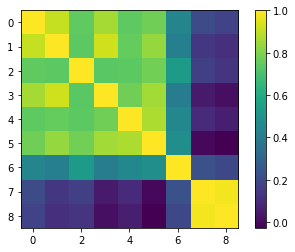

In [88]:
r = np.corrcoef(predictorsDF,rowvar=False)
plt.imshow(r)
plt.colorbar();

| Feature Label    | Feature Attribute |
| ----------- | ----------- |
| 0 |  Rigor of Instruction   |
| 1 |  Student-Teacher Collaboration |
| 2 |  Suppportiveness of Environment    |
| 3 |  Effectiveness of School Leadership   |
| 4 |  Strong Family and/or Community Ties    |
| 5 |  Trust within and in the School    |
| 6 |  OBJECTIVE MEASURE: Student Achievement   |
| 7 |  OBJECTIVE MEASURE: Students Exceeding Reading Scores    |
| 8 |  OBJECTIVE MEASURE: Students Exceeding Math Scores     |

I had originally wanted to continue feature analysis by running the data through **PCA (Principal Components Analysis)** however given even the visualization showing that there is little correlation between how students perceive their school and how the school objectively performs, I decided the PCA was not necessary in this case.

# 5. Evaluating How School Spending Influences HSPHS Acceptance Rate

Chi-Squared **($ X^{2} $)** tests are frequently used in the field of statistics and data science to determine whether there is a statistically significant difference between the expected frequences and the actual observed frequencies of an outcome within a contingency table. I made the choice to evaluate whether levels of school funding affected acceptance rates to a HSPHS with the null hypothesis $ H_{0} $ in this case being that levels of funding did not contribute to HSPHS acceptance in a statistically significant way.

In [96]:
#Create a new DataFrame comparing funding per student and acceptance to a HSPHS
hypothesisDF = middleSchoolDF[["per_pupil_spending", "applications", "acceptances"]]
hypothesisDF["acceptance_rate"] = (hypothesisDF.acceptances / hypothesisDF.applications) * 100

#Calculate median spending within each of the schools
medianSpending = hypothesisDF.per_pupil_spending.median()

#Separate the schools into categorical data using labels "Lesser Funding" or "Greater Funding"
hypothesisDF.per_pupil_spending[middleSchoolDF.per_pupil_spending <= medianSpending] = "Lesser Funding"
hypothesisDF.per_pupil_spending[middleSchoolDF.per_pupil_spending > medianSpending] = "Greater Funding"

#Likewise separate schools using labels "High Acceptance Rate" or "Low Acceptance Rate"
medianAcceptRate = hypothesisDF.acceptance_rate.median()
hypothesisDF.acceptance_rate[((middleSchoolDF.acceptances / middleSchoolDF.applications) * 100) <= medianAcceptRate] = "low acceptance rate"
hypothesisDF.acceptance_rate[((middleSchoolDF.acceptances / middleSchoolDF.applications) * 100) > medianAcceptRate] = "high acceptance rate"

#Add school name to the DataFrame for easier 1:1 visualization
hypothesisDF.insert(0, "School Name", middleSchoolDF["school_name"], True)
hypothesisDF.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,School Name,per_pupil_spending,applications,acceptances,acceptance_rate
0,P.S. 034 FRANKLIN D. ROOSEVELT,Greater Funding,6,0,low acceptance rate
1,P.S. 140 NATHAN STRAUS,Greater Funding,6,0,low acceptance rate
2,P.S. 184M SHUANG WEN,Lesser Funding,67,23,high acceptance rate
3,P.S. 188 THE ISLAND SCHOOL,Greater Funding,0,0,NaN
4,"TECHNOLOGY, ARTS, AND SCIENCES STUDIO",Greater Funding,11,0,low acceptance rate
5,UNIVERSITY NEIGHBORHOOD MIDDLE SCHOOL,Greater Funding,13,0,low acceptance rate
6,SCHOOL FOR GLOBAL LEADERS,Greater Funding,19,1,low acceptance rate
7,EAST SIDE COMMUNITY SCHOOL,Greater Funding,16,1,high acceptance rate
8,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",Lesser Funding,126,91,high acceptance rate
9,TOMPKINS SQUARE MIDDLE SCHOOL,Lesser Funding,66,14,high acceptance rate


Since I was able to successfully categorically label encode the data, I moved on to incorporating a chi-squared test in order to find a critical value within the contigency table and finding the degrees of freedom (dof) within the test results.

In [99]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

hypothesisContigency = pd.crosstab(hypothesisDF["per_pupil_spending"], hypothesisDF["acceptance_rate"])
#Print the contigency table from the data
print(hypothesisContigency)

acceptance_rate     high acceptance rate  low acceptance rate
per_pupil_spending                                           
Greater Funding                       68                  124
Lesser Funding                       139                   89


In [101]:
#Run contingency table through chi-squared test
stat, p, dof, expected = chi2_contingency(hypothesisContigency)
#Evaluate the degrees of freedom within the chi-squared test
print('dof = %d' % dof)
print(expected)

dof = 1
[[ 94.62857143  97.37142857]
 [112.37142857 115.62857143]]


In [103]:
#Interpret the test statistic and evaluate an initial result from the test
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Probability=%.3f, Critical=%.3f, Stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (Reject H_0)')
else:
	print('Independent (Failed to reject H_0)')

Probability=0.950, Critical=3.841, Stat=26.206
Dependent (Reject H_0)


In [104]:
#Interprets the p-value obtained from the chi-squared test
alpha = 1.0 - prob
print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (Reject H_0)')
else:
	print('Independent (Failed to Reject H_0)')

Significance=0.050, p=0.000
Dependent (Reject H_0)


My initial null hypothesis when regarding the relationship between the two features of the data was that funding would not affect HSPHS acceptance rate in a statistically significant way. However after running the chi-squared test on the label-encoded categorical data, I was left with a p-value of around $ 3.06 \times 10^{-7}$, much lower than the accepted critical p-value of 0.05, thus giving me grounds to reject my null hypothesis and conclude that school funding and HSPHS acceptance rate did indeed have a strong relation.

# 6. Availability of Resources and Achievement and Admission

Continuing on my previous evaluation of pure per-student spending of each school, I wanted to further expand on this analysis by incorporating other features such as availability of material resources and the impact these had on objective measures of achievement and also admission to a HSPHS.

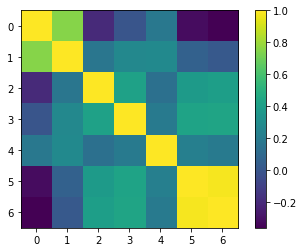

In [108]:
predictorDF = middleSchoolDF[["per_pupil_spending", "avg_class_size", "school_size", "acceptances",
                   "student_achievement", "reading_scores_exceed", "math_scores_exceed"]]

#Remove NaN values within any relevant data columns
predictorDF = np.nan_to_num(predictorDF)

#We need to see if a Principal Components Analysis is needed by looking at correlation
r = np.corrcoef(predictorDF,rowvar=False)
plt.imshow(r)
plt.colorbar();

| Feature Label    | Feature Attribute |
| ----------- | ----------- |
| 0 |  Per pupil spending  |
| 1 |  Average class size |
| 2 |  School size    |
| 3 |  Acceptance to a HSPHS   |
| 4 |  OBJECTIVE MEASURE: Student Achievement    |
| 5 |  OBJECTIVE MEASURE: Students Exceeding Reading Scores    |
| 6 |  OBJECTIVE MEASURE: Students Exceeding Math Scores  |


Analyzing the heatmap shows that there is a strong relationship between per pupil spending and average class size. This prompted me to calculate Pearson's Correlation Coefficient for these two variables to determine how closely correlated these two features within the data were. I then plotted the data to visualize the trend between the two features. 

In [113]:
perPupilSpending = middleSchoolDF["per_pupil_spending"]
avgClassSize = middleSchoolDF["avg_class_size"]

#Simple pre-processing to remove any NaN values
perPupilSpending = np.nan_to_num(perPupilSpending)
avgClassSize = np.nan_to_num(avgClassSize)

#Determine Pearson's r for the two features
r = np.corrcoef(perPupilSpending, avgClassSize)
r

array([[1.        , 0.75210707],
       [0.75210707, 1.        ]])

Determining that there was a Pearson's Correlation Coefficient of around 0.752 for the two specified features, and I then moved to plot this relation.

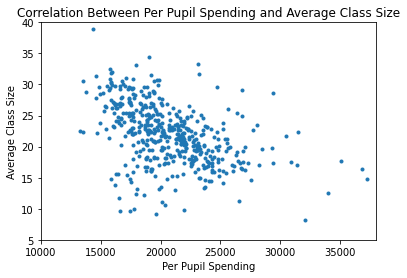

In [120]:
plt.plot(perPupilSpending, avgClassSize, "o", markersize = 3)
plt.title("Correlation Between Per Pupil Spending and Average Class Size")
plt.xlim(10000, 38000)
plt.xlabel("Per Pupil Spending")
plt.ylim(5, 40)
plt.ylabel("Average Class Size");

Although the correlation does show a decreasing but linear relationship between per pupil spending and average class size, analysis of the earlier heatmap surprisingly shows that there is very little correlation between availibility of material resources and the objective success of a school and also the increase of student acceptance to a HSPHS.

# 7. Proportion of Schools Which Account for 90% of HSPHS Acceptances

I wanted to determine how many of the top schools in terms of HSPHS acceptance accounted for the majority of acceptances into any HSPHS. 

In [144]:
hypothesisDF = middleSchoolDF[["school_name", "acceptances"]]

#Create a variable which sums up the total number of HSPHS acceptances across the city
totalAccept = hypothesisDF.acceptances.sum()
hypothesisDF["Percentage of Acceptances"] = (hypothesisDF.acceptances / totalAccept) * 100

#Sort the DataFrame based on decreasing rank order of percentage contribution to acceptances
sortedHypothesisDF = hypothesisDF.sort_values(by = ["Percentage of Acceptances"], ascending = False)
sortedHypothesisDF.reset_index(inplace=True)
sortedHypothesisDF.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,school_name,acceptances,Percentage of Acceptances
0,304,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,205,4.595382
1,324,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,196,4.393634
2,33,J.H.S. 054 BOOKER T. WASHINGTON,150,3.362475
3,241,M.S. 51 WILLIAM ALEXANDER,122,2.734813
4,22,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,113,2.533064


We have now organized our DataFrame such that we can see the individual contribution each school has in terms of HSPHS acceptance. We now perform some simple calculations and manipulations on the DataFrame in order to determine how many schools it takes to account for over 90% of overall HSPHS acceptance.

In [157]:
count = 0
percentContributed = 0
while percentContributed < 90:
  percentContributed += sortedHypothesisDF.loc[count,"Percentage of Acceptances"]
  count += 1
percentage = float((count / 594) * 100)
print(str(count) + " schools contributed to 90% of overall HSPHS acceptance. Given" +
      " 594 middle schools within New York City,\nthis means that " + str('{:.2f}'.format(percentage)) + 
      "% of the top schools accounted for 90% of city-wide admission to any HSPHS.")

123 schools contributed to 90% of overall HSPHS acceptance. Given 594 middle schools within New York City,
this means that 20.71% of the top schools accounted for 90% of city-wide admission to any HSPHS.


After analyis of the sorted DataFrame, we find that **20.71%** of the top schools ranked by total contributed acceptance rate accounted for over 90% of admission into any HSPHS within NYC. This result is surprising as it shows just how top-heavy the acceptance rates are within schools for admissions to these high selective schools.

# 8. Incorporating Clustering to Determine All Influential Factors

Since I reviewed most of the factors independently which could have contributed to HSPHS acceptance and also evaluated the correlations between different factors, I found it most relevant to build a model on a clustering algorithm in order to determine the most important school characteristics within a school.

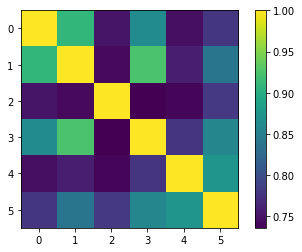

In [178]:
predictors = data[["rigorous_instruction", "collaborative_teachers", "supportive_environment", "effective_school_leadership",
                   "strong_family_community_ties", "trust"]].to_numpy()

#Remove NaN values in simple first pre-processing step
predictors = np.nan_to_num(predictors)

#Checking correlation in order to evaluate the need for a PCA
r = np.corrcoef(predictors,rowvar=False)
plt.imshow(r)
plt.colorbar();

After constructing the heatmap between the relationship of the values, I decided to run a Principal Components Analysis to further analyze the relationship between the features in the data.

In [181]:
#I first z-score the data so that it is consistent all categories so it can be compared, essentially
#trying to "compare apples to apples"
zscoredData = stats.zscore(predictors)

#We then fit the PCA onto the z-scored data
pca = PCA().fit(zscoredData)

#Explore the eigenvalues within the PCA
eigen = pca.explained_variance_ 

#Make a loadings matrix of the components within the PCA
loadings = pca.components_ *-1
origDataNewCoordinates = pca.fit_transform(zscoredData) *-1

After successfully fitting the z-scored data onto a PCA, I moved to produce a Scree plot from PCA in order to determine eigenvalue weight in the context of the factors within the data.

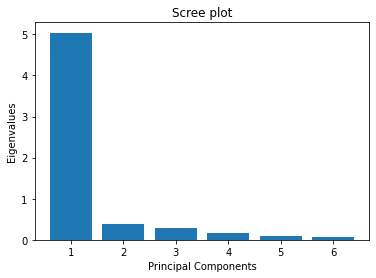

In [184]:
numPredictors = 6
plt.bar(np.linspace(1,numPredictors,numPredictors),eigen)
plt.title('Scree plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues');

It can clearly be see that one factor holds the majority of the weight within the plot's eigenvalues. By evaluating the weight of this factor using both Elbow and Kaiser criterion for evaluating eigevalues validity, it can be confident in saying that this one factor is more than sufficient to influence success outcomes. Therefore I then moved to inspect the loadings matrix of this one factor.

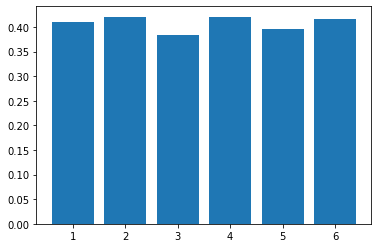

In [189]:
#Loadings Matrix for Factor 1 (Overall Structure of School and Environment): 
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[0,:]);

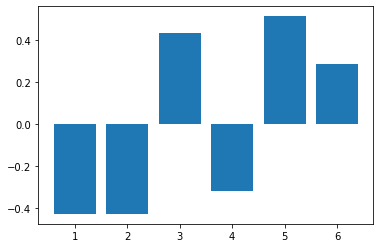

In [190]:
#Loadings Matrix for Factor 2 (Support, Family, Community Ties, and Trust): 
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[1,:]);

The loading matrix for the first factor is evenly distributed, suggesting that all six factors are heavily influential in determining this factor, implying that this one principal component determines the majority of outcomes.

Looking at the loading matrix for the second factor shows that some factors are negative influences while some are positive influences within the loading matrix. This also gives us more concrete analysis of the second factor, however its influence on outcomes is still minor.

# 9. Summary: Understanding Characteristics and Relevance

Throughout the analysis of this program, many of the factors I originally though would affect student and school performance were not as correlated as I had originally thought. An example of this would be that there was a lack of correlation between student perception of their school and student and school performance. Additionally availability of resources, which included factors such as smaller class sizes, did not have as much of a correlation with overall objective measures of success as I originally thought.

Speaking of other factors however, I was surprised to also find that pure numbers of applications to a HSPHS had a much higher correlation constant than the application rate of a school. However after analysis of many other factors within the dataset, the most relevant features within the dataset seem to be school spending in terms of average spending per pupil and also just in terms of raw applications to any HSPHS.




-

# Recommendations within Data Science Scope for NYC DOE

With regards to basic recommendations for the New York City Department of Education, I would first recommend improved rates of acceptance to any HSPHS by increasing interest and sheer numbers of applicants to HSPHS. This is because there is a huge disparity in terms of pure applications to any HSPHS. This along with the incredibly positively correlatelated amount of students that get into a HSPHS and the number of applications per school cannot be ignored in terms of facilitating student success. Finally, I would push for higher per pupil spending rather than other factors of material availability as per pupil spending showed the most promise in terms of its correlation to increasing the number of students that would be accepted into a HSPHS. In the same way, the simplest way to influence the improvement and increase of objective measures of achievement within a school would also be increased by this increase in per pupil spending.